<a href="https://colab.research.google.com/github/bilzard/JQuants-news/blob/main/Ex01_JQuants_news_evaluation_1st_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

評価期間第一週に提出した全参加者のスコアの分布と、提出したモデルの統計的な特徴について簡単に調べてみました。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

データソースはSIGNATEのPrivateLBをコピペしたものを加工して作っています。

In [154]:
lb_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JPX_Competition/JQuants-news_leaderboard.csv')

In [155]:
lb_df = lb_df.replace({'-': np.nan}).dropna()
lb_df['最終評価 ▼'] = lb_df['最終評価 ▼'].astype(float)
lb_df['暫定評価'] = lb_df['暫定評価'].astype(float)
lb_df['推論時間 (sec)'] = lb_df['推論時間 (sec)'].astype(float)
lb_df['投稿件数'] = lb_df['投稿件数'].astype(float)

lb_df.rename(columns={'最終評価 ▼': 'Private LB', '推論時間 (sec)': 'PredTimeSec', '暫定評価': 'Public LB', '投稿件数': 'Submissions'}, inplace=True)

In [156]:
lb_df.head()

,順位,チーム名 / ユーザ名,PredTimeSec,Public LB,Private LB,Submissions,投稿日時,term
0,1,Ken.Ken.,5198.650,25701.3,-6114.4,1.0,2021-05-17 19:26:15,1
1,2,nakayasu,5112.404,60157.0,-12551.0,5.0,2021-05-17 19:26:14,1
2,3,FYSignate1009,332.109,27829.0,-16534.0,3.0,2021-05-17 17:54:05,1
3,4,takyan,6481.370,23375.0,-17608.0,3.0,2021-05-17 19:36:04,1
4,5,client_first,11.917,87766.3,-19128.9,15.0,2021-05-17 17:51:20,1


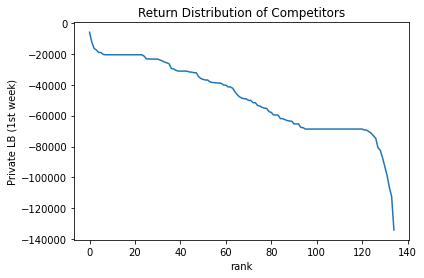

In [157]:
df = lb_df['Private LB']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(df)
ax.set_xlabel('rank')
ax.set_ylabel('Private LB (1st week)')

ax.title.set_text('Return Distribution of Competitors')

まず、第一週のPrivate LB のスコアをプロットします。
特異な2山の分布をしていますが、-2.0万円と-6.8万円付近にあるピークは、チュートリアルのモデルをそのまま提出したユーザの一群とおもわれます。

mean: -48286
std: 23399
p90: -20675
median: -48685


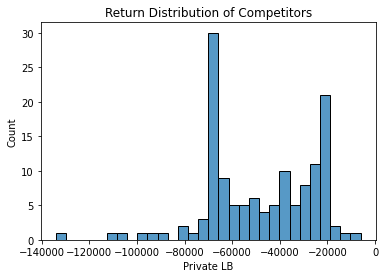

In [158]:
df = lb_df['Private LB']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(df, bins=30, ax=ax)
ax.title.set_text('Return Distribution of Competitors')

print(f'mean: {df.mean():.0f}')
print(f'std: {df.std():.0f}')
print(f'p90: {df.quantile(.9):.0f}')
print(f'median: {df.median():.0f}')

チュートリアルのモデルを除外した分布もプロットします。裾野の重い1山の分布です。

mean: -47624
std: 23335
p90: -23404
median: -41877


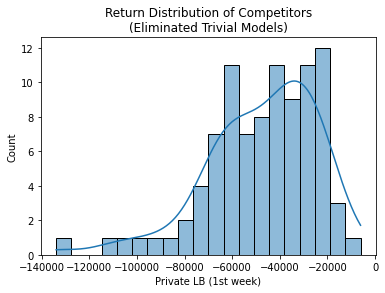

In [166]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, 'Private LB']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(df, bins=20, ax=ax, kde=True)
ax.set_xlabel('Private LB (1st week)')
ax.title.set_text('Return Distribution of Competitors\n(Eliminated Trivial Models)')

print(f'mean: {df.mean():.0f}')
print(f'std: {df.std():.0f}')
print(f'p90: {df.quantile(.9):.0f}')
print(f'median: {df.median():.0f}')

## 提出したモデルの統計的特徴

参考までに、推論時間、Submission回数、Public LB, Private LB の4項目について相関をみてみます（以下の分析ではチュートリアルのモデルのスコアを除外しています）。

In [233]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, ['PredTimeSec', 'Submissions', 'Public LB', 'Private LB']]
df.corr('pearson').round(3)

,PredTimeSec,Submissions,Public LB,Private LB
PredTimeSec,1.000,-0.040,-0.321,0.143
Submissions,-0.040,1.000,0.381,-0.164
Public LB,-0.321,0.381,1.000,-0.187
Private LB,0.143,-0.164,-0.187,1.000


まず、推論時間とPrivate LB に若干正の相関があります。第一週の評価では長考型モデルのほうが即答型のモデルに若干勝っているといえます。

また、Public LB と Private LB は逆相関になっています。要因としては、Publicスコアが高いモデルは期待値が高くてリスクの高いポートフォリオを組んでいると思われるため、マイナスに触れたときのロスが大きいこと、また、Public のスコアに対して過学習してしまったことなどが考えられます。

なお、興味深いことに、Submissioins と Public LB にはわりと強い正の相関があります。Public LB を改善するためにSubmissionを重ねたユーザが一定数いたことが想像できます。
今回のコンペは課題の性質からいうと、Public LB のスコアはあまりあてにならなかったのですが、「目に見えるスコアを少しでもよくしたい」という人間特有の心理が働いたのかもしれません。

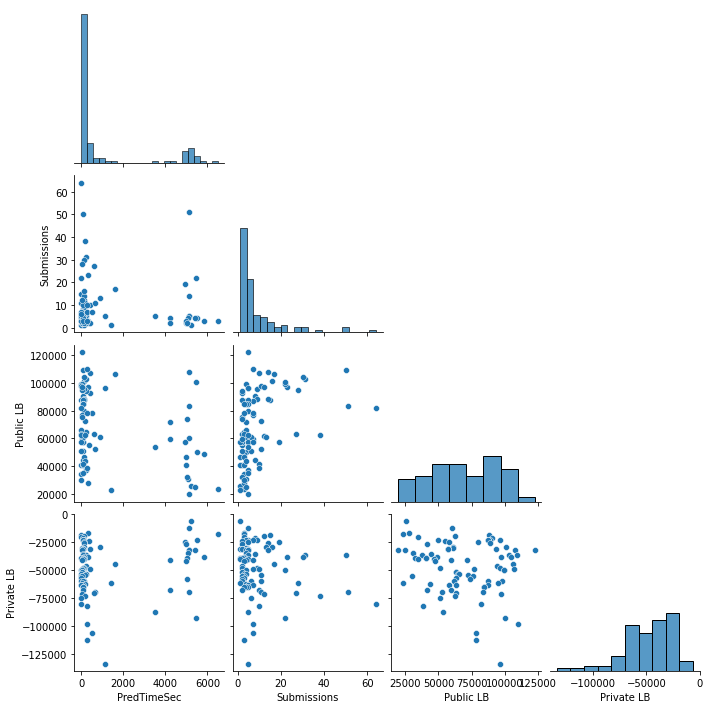

In [174]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, ['PredTimeSec', 'Submissions', 'Public LB', 'Private LB']]
sns.pairplot(df, corner=True, diag_kind='auto')

変数間のみかけの依存を排除するために、これらを排除した偏相関係数を求めます。

pingouin ライブラリを使います。
https://pingouin-stats.org/

In [228]:
! pip install pingouin

In [229]:
import pingouin as pg

In [244]:
pg.pcorr(df).round(3)

,PredTimeSec,Submissions,Public LB,Private LB
PredTimeSec,1.000,0.104,-0.318,0.100
Submissions,0.104,1.000,0.374,-0.111
Public LB,-0.318,0.374,1.000,-0.097
Private LB,0.100,-0.111,-0.097,1.000


Submission と Private LB にいくらか相関があります。また、PredTimeSecとPublicLBにいくらか負の相関があります。

逆に、Public LB と Private LBの相関は小さくなっています。

PredTimeSec, Submissions, Public LB の偏相関についてもう少し詳しく分析します。

ペアごとの偏相関の結果から、以下のことがわかります：

* 推論時間はPublicLBと負の相関がある
* サブミッション数はPublic LB と正の相関がある
* 推論時間とサブミッション数には相関があるとはいえない

なお、Private LB はモデル提出の時点でわからない値なので、偏相関を計算するときの制御変数からは除外しています。

In [240]:
pg.partial_corr(df, x='Submissions', y='Public LB', covar=['PredTimeSec'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,0.389362,"[0.2, 0.55]",0.151603,0.132538,0.000125,181.884,0.9736


In [245]:
pg.partial_corr(df, x='PredTimeSec', y='Public LB', covar=['Submissions'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,-0.331129,"[-0.5, -0.14]",0.109646,0.089638,0.001264,21.703,0.903527


In [246]:
pg.partial_corr(df, x='Submissions', y='PredTimeSec', covar=[])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,-0.040343,"[-0.24, 0.17]",0.001628,-0.020808,0.702597,0.14,0.06675


次に、推論時間、サブミッション数、Public LBとPrivate LBの偏相関について同様の分析をします。

* サブミッション数、推論時間、Public LB のいずれも、 Private LB と相関があるとはいえない

In [275]:
pg.partial_corr(df, x='Public LB', y='Private LB', covar=['Submissions', 'PredTimeSec'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,-0.097214,"[-0.3, 0.11]",0.009451,-0.012809,0.356591,0.198,0.151959


In [276]:
pg.partial_corr(df, x='Submissions', y='Private LB', covar=['Public LB', 'PredTimeSec'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,-0.111312,"[-0.31, 0.1]",0.01239,-0.009803,0.290807,0.226,0.185


In [277]:
pg.partial_corr(df, x='PredTimeSec', y='Private LB',  covar=['Submissions', 'Public LB'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,92,0.099874,"[-0.11, 0.3]",0.009975,-0.012273,0.343521,0.203,0.157826


最後のコードはおまけで、偏相関係数が0.3以上の特徴量どうしを線でつないだグラフを表示します。

コードはこちらから借りました。
https://qiita.com/studio_haneya/items/0a67b951e0e72670cd6f

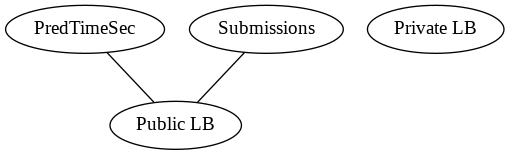

In [235]:
from graphviz import Graph
from PIL import Image

def draw_graph(cm, threshold):
    edges = np.where(np.abs(cm) > threshold)
    edges = [[cm.index[i], cm.index[j]] for i, j in zip(edges[0], edges[1]) if i > j]

    g = Graph(format='png')
    for k in range(cm.shape[0]):
        g.node(cm.index[k])

    for i, j in edges:
        g.edge(j, i)

    g.render(filename='../test', format='png', cleanup=True, directory=None)
    display(Image.open('../test.png'))

threshold = 0.3
draw_graph(pg.pcorr(df), threshold)

## 最後に

第一週は残念ながらすべてのモデルがマイナス評価となりました。
学習に使った特徴量では説明のつかない要因によって、市場が大きく影響を受けたことが想像できます（詳しい原因の分析と考察は専門家におまかせします）。

第二週はプラス評価のモデルが出ることを祈ります。